# Detekce jazyka


In [1]:
import wikipediaapi
import random
import string
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tabulate import tabulate

LANGUAGES = {
    'čeština': 'cs',
    'angličtina': 'en',
    'němčina': 'de',
    'francouzština': 'fr',
    'španělština': 'es',
    'italština': 'it',
    'latina': 'la',
}

POPULAR_PAGES = {
    'cs': ['Česko', 'Bedřich_Smetana', 'Periodická_tabulka', 'Praha', 'Jaromír_Jágr'],
    'en': ['United_States', 'Elizabeth_II', 'Periodic_table', 'United_Kingdom', 'Eminem'],
    'de': ['Deutschland', 'Goethe', 'Periodensystem', 'Berlin', 'Albert_Einstein'],
    'fr': ['France', 'Victor_Hugo', 'Tableau_périodique_des_éléments', 'Paris', 'Louis Pasteur'],
    'es': ['España', 'Don_Quijote', 'Tabla_periódica_de_los_elementos', 'Madrid', 'Rafael_Nadal'],
    'it': ['Italia', 'Giuseppe_Verdi', 'Tavola_periodica_degli_elementi', 'Roma', 'Leonardo_da_Vinci'],
    'la': ['Italia', 'Iosephus_Verdi', 'Systema_periodicum', 'Roma', 'Leonardus_Vincius'],
}

N_GRAM_SIZES = [1, 2, 3]
SMOOTHING_PROB = 1e-6
LOG_SMOOTHING_PROB = math.log(SMOOTHING_PROB)
TEXT_LENGTH_LIMIT = 128000
LATIN_ALPHABET = list(string.ascii_uppercase)
WIKI_APIS = {
    code: wikipediaapi.Wikipedia(language=code, user_agent='DetekceJazyka (test@test.com)')
    for code in LANGUAGES.values()
}

def get_page_text_wikiapi(lang_code, title):
    wiki = WIKI_APIS.get(lang_code)
    
    try:
        page = wiki.page(title)
        return page.text if page.exists() else ""
    except Exception:
        return ""

def preprocess_text(text):
    text = re.sub(r'\\{\\{.*?\\}\\}|\\[\\[.*?\\]\\]|\\[.*?\\]', ' ', text, flags=re.S)
    text_processed = ''.join(c.lower() for c in text if c.isalpha())
    
    return text_processed

def generate_ngrams(text, n):
    if len(text) < n:
        return []

    return (text[i:i+n] for i in range(len(text) - n + 1))


In [2]:
corpus_raw_api = defaultdict(str)

for lang_name, lang_code in LANGUAGES.items():
    if lang_code not in POPULAR_PAGES:
        print(f"Stahuji jazyk {lang_name} ... Stahování selhalo: Neznámý kód jazyka")
        continue

    print(f"Stahuji jazyk {lang_name} ...", end='', flush=True)

    current_text = ""
    page_index = 0
    is_successful = False

    while len(current_text) < TEXT_LENGTH_LIMIT:
        try:
            title = POPULAR_PAGES[lang_code][page_index % len(POPULAR_PAGES[lang_code])]
            page_index += 1
            new_text = get_page_text_wikiapi(lang_code, title)
            processed_text = preprocess_text(new_text)

            if not processed_text:
                if page_index > len(POPULAR_PAGES[lang_code]) * 2 and not current_text:
                    break
                continue
            
            remaining = TEXT_LENGTH_LIMIT - len(current_text)
            current_text += processed_text[:remaining]

            if len(current_text) >= TEXT_LENGTH_LIMIT:
                is_successful = True
                break
                
        except Exception:
            break 
            
    corpus_raw_api[lang_name] = current_text

    if is_successful:
        print(f" Dokončeno")
    else:
        print(f" Stahování selhalo: nedosažena plná délka korpusu")

CORPUS = corpus_raw_api


Stahuji jazyk čeština ... Dokončeno
Stahuji jazyk angličtina ... Dokončeno
Stahuji jazyk němčina ... Dokončeno
Stahuji jazyk francouzština ... Dokončeno
Stahuji jazyk španělština ... Dokončeno
Stahuji jazyk italština ... Dokončeno
Stahuji jazyk latina ... Dokončeno


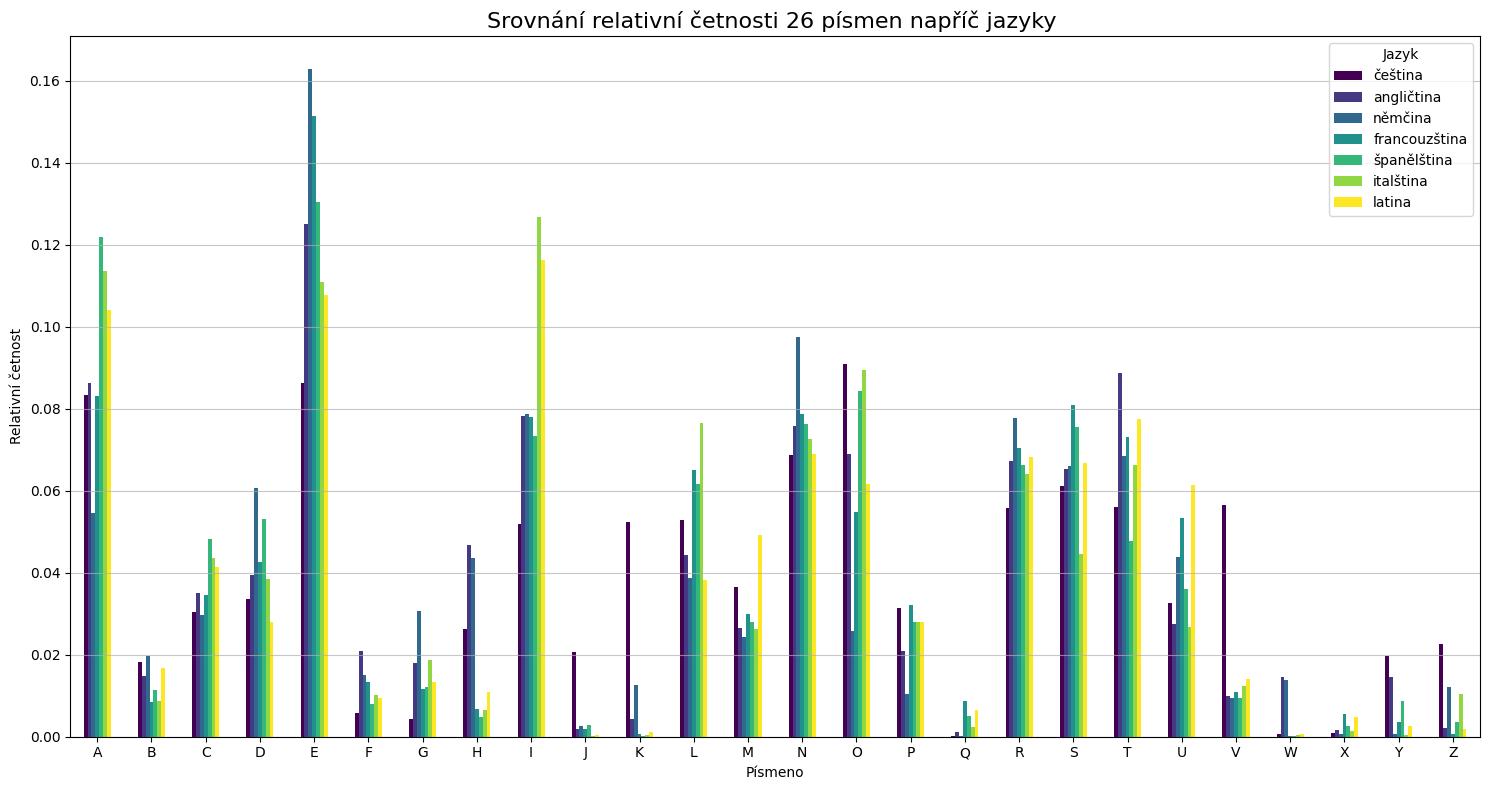

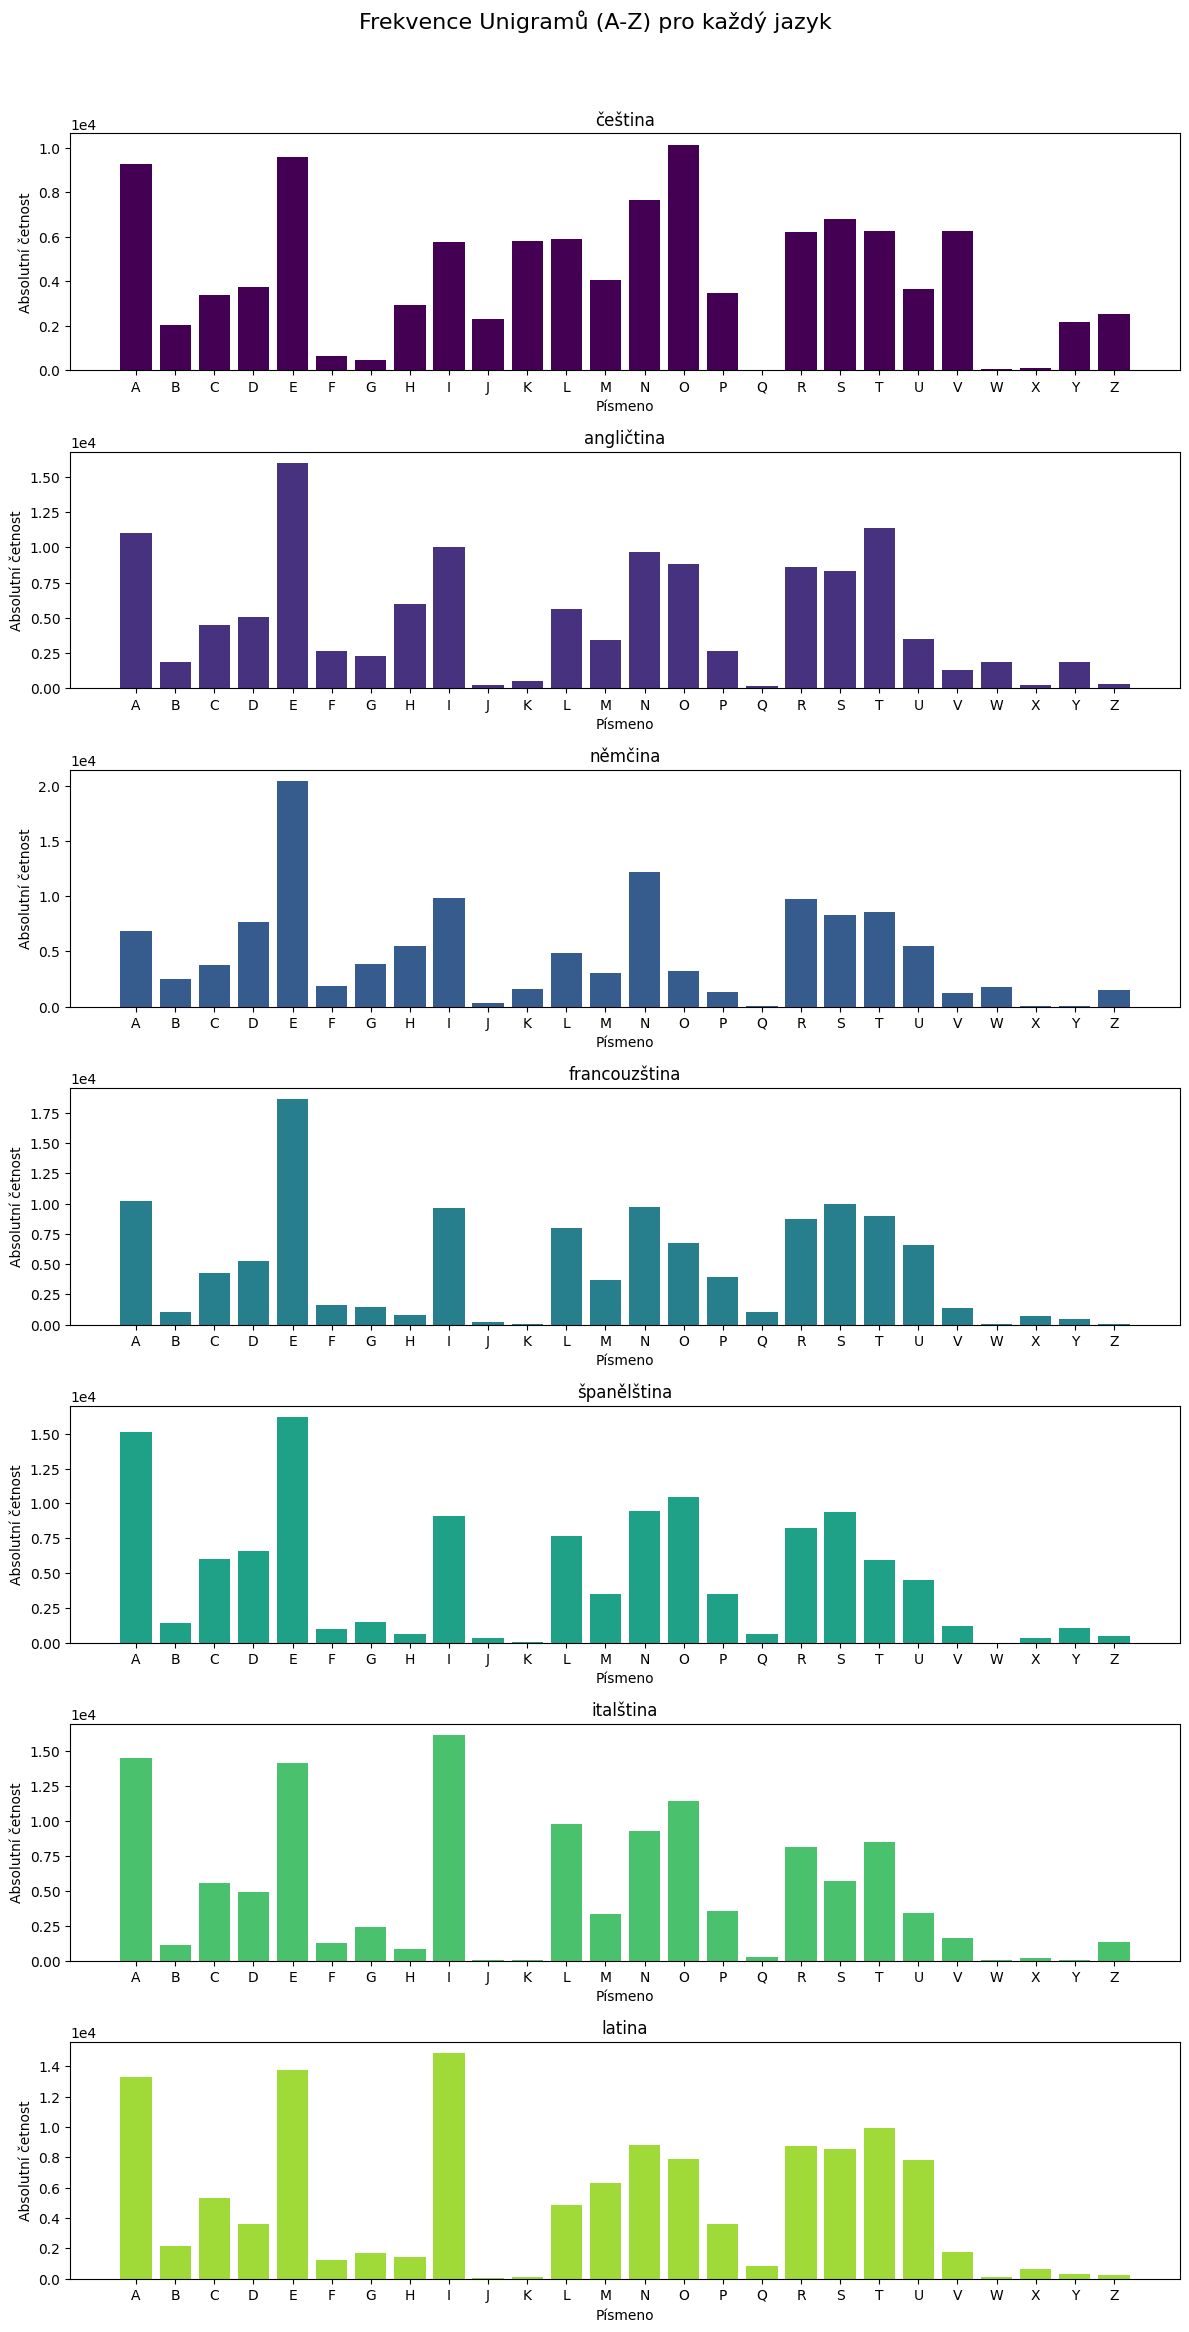

In [3]:
def create_language_model(corpus, n_gram_sizes):
    model = defaultdict(lambda: defaultdict(dict))
    
    for lang, text in corpus.items():
        if not text:
            continue
            
        for n in n_gram_sizes:
            n_gram_counts = Counter(generate_ngrams(text, n))
            
            if not n_gram_counts:
                continue
                
            total_ngrams = sum(n_gram_counts.values())
            model[lang][n]['counts'] = n_gram_counts
            log_total = math.log(total_ngrams)
            log_prob_model = {
                ngram: math.log(count) - log_total
                for ngram, count in n_gram_counts.items()
            }
            model[lang][n]['log_probabilities'] = log_prob_model

    return model

LANGUAGE_MODEL = create_language_model(CORPUS, N_GRAM_SIZES)

def visualize_combined_unigrams(model):
    all_unigrams_data = {}
    chars_to_plot = LATIN_ALPHABET 
    
    for lang in LANGUAGES.keys():
        unigram_counts = model[lang][1]['counts']
        filtered_counts = {k: v for k, v in unigram_counts.items() if k.isalpha() and k in string.ascii_lowercase}
        total_unigrams = sum(filtered_counts.values())
        
        lang_data = {}
        for char in chars_to_plot:
            count = filtered_counts.get(char.lower(), 0)
            relative_freq = count / total_unigrams if total_unigrams > 0 else 0
            lang_data[char] = relative_freq
            
        all_unigrams_data[lang] = lang_data
        
    df_plot = pd.DataFrame(all_unigrams_data, index=chars_to_plot)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    df_plot.plot(kind='bar', ax=ax, colormap='viridis')
    
    ax.set_title('Srovnání relativní četnosti 26 písmen napříč jazyky ', fontsize=16)
    ax.set_xlabel('Písmeno')
    ax.set_ylabel('Relativní četnost')
    ax.legend(title='Jazyk')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='-', alpha=0.7)
    plt.tight_layout()
    plt.show()

def visualize_individual_unigrams(model):
    num_langs = len(LANGUAGES)
    fig, axes = plt.subplots(num_langs, 1, figsize=(12, 3.5 * num_langs))
    fig.suptitle('Frekvence Unigramů (A-Z) pro každý jazyk', fontsize=16)
    chars_to_plot = LATIN_ALPHABET
    
    if num_langs == 1:
        axes = [axes]
        
    for i, lang in enumerate(LANGUAGES.keys()):
        if lang not in model or 1 not in model[lang] or 'counts' not in model[lang][1]:
            continue 

        unigram_counts = model[lang][1]['counts']
        counts_for_plot = []
        
        for char_upper in chars_to_plot:
            char_lower = char_upper.lower()
            count = unigram_counts.get(char_lower, 0)
            counts_for_plot.append(count)
        
        ax = axes[i]
        ax.bar(chars_to_plot, counts_for_plot, color=plt.cm.viridis(i/num_langs))
        ax.set_title(f'{lang}', fontsize=12)
        ax.set_xlabel('Písmeno')
        ax.set_ylabel('Absolutní četnost')
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

if LANGUAGE_MODEL:
    visualize_combined_unigrams(LANGUAGE_MODEL)
    visualize_individual_unigrams(LANGUAGE_MODEL)


In [4]:
def select_ngrams(text, n_gram_sizes, n_samples=50):
    processed_text = preprocess_text(text)
    selected_ngrams = []
    text_len = len(processed_text)
    
    for n in n_gram_sizes:
        max_n_grams = max(0, text_len - n + 1)
        
        if max_n_grams == 0:
            continue
            
        k = min(n_samples, max_n_grams)
        start_indices = random.sample(range(max_n_grams), k)
        new_ngrams = [processed_text[i:i+n] for i in start_indices]
        selected_ngrams.extend(new_ngrams)
        
    return selected_ngrams

def classify_language(text, model, n_gram_sizes):    
    test_ngrams = select_ngrams(text, n_gram_sizes)
    
    if not test_ngrams:
        return "Nelze klasifikovat: Příliš krátký nebo prázdný text.", {}

    log_smoothing_prob = LOG_SMOOTHING_PROB 
    results = {}
    
    lang_model_map = {
        lang: {
            n: model[lang][n].get('log_probabilities', {})
            for n in n_gram_sizes
            if n in model[lang]
        }
        for lang in LANGUAGES.keys()
    }
    
    for lang in LANGUAGES.keys():
        total_log_prob = 0.0
        current_lang_map = lang_model_map[lang]
        
        for ngram in test_ngrams:
            n = len(ngram)
            
            log_prob_model = current_lang_map.get(n)
            
            if log_prob_model:
                log_prob = log_prob_model.get(ngram, log_smoothing_prob)
            else:
                log_prob = log_smoothing_prob
                
            total_log_prob += log_prob
        
        results[lang] = total_log_prob
        
    best_guess = max(results, key=results.get)
    return best_guess, results

test_examples = {
    "angličtina": "Do not go gentle into that good night, Old age should burn and rave at close of day, Rage, rage against the dying of the light.",
    "čeština": "Do dobré noci té nekráčej ve fraku, Stáří ať burácí, soptí, když hasne den, běsni jen, běsni jen dál, protiv soumraku.",
    "němčina": "Geh' Du nicht sanft in jene Gute Nacht, Das Alter soll ein Loh'n, ein Wüten sein, Zürn, zürn dem Dunkeln Deiner Sonne Pracht.",
    "francouzština": "N’entre pas sans violence dans cette bonne nuit, Le vieil âge devrait brûler et s’emporter à la chute du jour, Rage, rage encore, lorsque meurt la lumière.",
    "španělština": "No entres dócilmente en esa noche quieta, Que delire la vejez y se queme al cabo del día, Brama contra la agonía de la luz e impreca.",
    "italština": "Non andartene docile in quella buona notte, vecchiaia dovrebbe ardere e infierire quando cade il giorno, infuria, infuria contro il morire della luce.",
    "latina": "Homerus clarus graecorum poeta erat.",
    "portugalština": "Não vás tão docilmente nessa noite linda, Que a velhice arda e brade ao término do dia, Clama, clama contra o apagar da luz que finda.",
    "esperanto": "Unu bieron, mi petas."
}

for description, text in test_examples.items():
    best_guess, log_probs = classify_language(text, LANGUAGE_MODEL, N_GRAM_SIZES)
    print("-" * 55)
    
    if isinstance(best_guess, str) and best_guess.startswith("Nelze klasifikovat"):
        print(f"Text v jazyce {description.capitalize()}.")
        print(f"*{text.replace('\n', ' ')}*\n")
        print(f"**NEJLEPŠÍ ODHAD:** {best_guess}")
        print("-" * 55 + "\n") 
        continue
    
    sorted_log_probs = sorted(log_probs.items(), key=lambda item: item[1], reverse=True)
    table_data = []

    for lang, log_prob in sorted_log_probs:
        is_best = '✅' if lang == best_guess else ' '
        lang_name_formatted = lang.capitalize()
        table_data.append([lang_name_formatted, f"{log_prob:.2f}", is_best])
    
    print(f"Text v jazyce {description.capitalize()}.")
    print(f"*{text.replace('\n', ' ')}*\n")
    print("Tabulka s pravděpodobnostmi jazyka textu")
    print("-" * 55)
    headers = ["Jazyk", "Logaritmická Pravděpodobnost", ""]
    print(tabulate(table_data, headers=headers, tablefmt="pipe", numalign="right"))
    print("-" * 55 + "\n")


-------------------------------------------------------
Text v jazyce Angličtina.
*Do not go gentle into that good night, Old age should burn and rave at close of day, Rage, rage against the dying of the light.*

Tabulka s pravděpodobnostmi jazyka textu
-------------------------------------------------------
| Jazyk         |   Logaritmická Pravděpodobnost |    |
|:--------------|-------------------------------:|:---|
| Angličtina    |                         -841.5 | ✅ |
| Němčina       |                         -965.3 |    |
| Latina        |                        -971.59 |    |
| Francouzština |                        -981.03 |    |
| Italština     |                       -1004.84 |    |
| Čeština       |                       -1011.03 |    |
| Španělština   |                       -1017.28 |    |
-------------------------------------------------------

-------------------------------------------------------
Text v jazyce Čeština.
*Do dobré noci té nekráčej ve fraku, Stáří ať burác

## Výstup pro načené jazyky
Z prvních 7 výsledků je patrné, že texty v jednotlivých předučených jazycích jsou správně rozpoznávány. Podobnost jazyků patřících do totožné jazykové rodiny je správně vyjádřena podobnými logaritmickými pravděpodobnostmi.

## Výstup pro nenaučené jazyky
Pro kontrolu, zdali lze určit nejpodobnější naučený jazyk v jazyce textu, který nebyl naučen, jsem otestoval portugalštinu a esperanto.

Portugalštině byla správně přiřazena podobnost se španělštinou a u esperanta byla správně vyhodnocena jako nejpravděpodobnější jazyk latina, která esperantu posloužila jako základ slovní zásoby.
